In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 0. Introduction
This explorative data analysis (EDA) examines the landscape of US nursing homes, using data from the Centers for Medicare & Medicaid Services (CMS), along with county-level census data from the US Bureau of Economics Analysis and the US Census Bureau. 

The analysis aims to answer two key questions:
1. **Ownership disparities:**
    Are there variations in quality of care and staffing attributes across different ownership categories: non-profit, for-profit, and government?
2. **County demographics disparities:**
    Are there potential correlations between the demographic profile of the county (urban/rural setting, median personal income per capita) and diverse characteristics exhibited by nursing homes?

## 1. County-level census data
Load and clean demographic data for US counties, focusing on essential metrics:
- Personal income per capita per county in 2020 (source: US Bureau of Economic Analysis https://www.bea.gov/news/2023/personal-income-county-and-metropolitan-area-2022)
- County-level urban and rural information for the 2020 Census (source: US Census Bureau https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural.html )

Data are presented as one row per US county.

In [5]:
# Get personal income per capita per county
#pi_path = 'C:/Users/nhatp/Desktop/DS5230/nursinghome/data/raw/lapi1123.csv'
pi_path = 'https://raw.githubusercontent.com/nhathpham/US-Nursing-Home/main/lapi1123.csv'
pi = pd.read_csv(pi_path)
pi = pi[['state','county','pi_2020']]
display(pi.head(3))

# Get % urban land per county
#pop_path = 'C:/Users/nhatp/Desktop/DS5230/nursinghome/data/raw/2020_UA_COUNTY.csv'
pop_path = 'https://raw.githubusercontent.com/nhathpham/US-Nursing-Home/main/2020_UA_COUNTY.csv'
pop = pd.read_csv(pop_path)
pop.columns = pop.columns.str.lower()
pop = pop[['state_name','county_name','aland_pct_urb']]
pop = pop.rename(columns={'state_name': 'state','county_name':'county'})
display(pop.head(3))

# State name and abbreviation
#state_path = 'C:/Users/nhatp/Desktop/DS5230/nursinghome/data/raw/states.csv'
state_path = 'https://raw.githubusercontent.com/nhathpham/US-Nursing-Home/main/states.csv'
states = pd.read_csv(state_path)

,state,county,pi_2020
0,United States,NaN,"59,153"
1,Alabama,NaN,"45,887"
2,Alabama,Autauga,"45,151"


,state,county,aland_pct_urb
0,Alabama,Autauga,3.63%
1,Alabama,Baldwin,8.62%
2,Alabama,Barbour,0.70%


In [4]:
# Merge county data, each row is a county
cou_data = pd.merge(pi, pop, on=['state', 'county'], how='inner')
cou_data = pd.merge(cou_data, states, on='state', how='inner')
# Remove 'state' column and rename 'abbreviation' as 'state'
cou_data = cou_data.drop(['state'], axis=1)
cou_data = cou_data.rename(columns={'abbreviation': 'state'})
def clean_convert(column):
    return column.str.replace(',', '').str.rstrip('%').astype(float)
cols_to_clean = ['pi_2020', 'aland_pct_urb']
cou_data[cols_to_clean] = cou_data[cols_to_clean].apply(clean_convert)
cou_data.head(2)

,county,pi_2020,aland_pct_urb,state
0,Autauga,45151.0,3.63,AL
1,Baldwin,51230.0,8.62,AL


## 2. CMS data

This dataset from the CMS provides information on 14,875 currently active nursing homes in the US, including number of certified beds, quality measure scores, staffing and other information used in the Five-Star Rating System. Data are presented as one row per nursing home.

### 2.1 Load data

In [6]:
#cms_path = 'C:/Users/nhatp/Desktop/DS5230/nursinghome/data/raw/NH_ProviderInfo_Nov2023.csv'
cms_path = 'https://raw.githubusercontent.com/nhathpham/US-Nursing-Home/main/NH_ProviderInfo_Nov2023.csv'
cms_raw = pd.read_csv(cms_path)

14924

### 2.2 Clean and filter data

- Derive new variables:
    - time_in_practice = processing_date - date_first_approved_to_provide_medicare_and_medicaid_services columns: estimates the operational duration in years.
    - avg_occupancy_ratio = average_number_of_residents_per_day/ number_of_certified_beds: indicates the average occupancy level of the facility.
- Remove columns not relevant to the analyses, highly correlate with others, or are mostly nulls:
    - Based on CMS' document, overall_rating is derived from health_inspection_rating, qm_rating, and staffing_rating. Correlation matrix shows that long_stay_qm_rating and short_stay_qm_rating highly correlates with qm_rating so we keep the two individual QM metrics.
    - Staffing hour metrics have three types of measure: Reported (Actual staffing hours reported by a nursing home), Case-mix (Staffing hours adjusted based on resident care needs), and Adjusted (Standardized metric considering national averages for benchmarking). We focus on Case-mix metrics only as they provide adjusted values based on resident care needs, ensuring standardized comparisons. 
    - Deficiency Metrics: Kept contributing values (RC1_standard_deficiencies, RC1_complaint_deficiencies) instead of total values for clarity
    - Health Score Metrics: Retained contributing values (RC1_health_deficiency_score, RC1_health_revisit_score) instead of the total health score for clarity
    - Provider Type: Removed due to highly skewed distribution (over 90% Medicaid and Medicare).
    - Rating Cycles: Selected only Rating cycle 1 assessments for analysis, discarding older assessments (Rating cycles 2 and 3).
    - Remove "footnote" columns due to predominantly null values
- Removed rows with NaN values for ratings that are not associated with Special Focus Facilities, as Special Focus Facilities lack rating metrics.

In [8]:
cms = cms_raw.copy()
# Lowercase column titles and replace punctuations with underscore to make them one word
cms.columns = [col.lower().replace(' ', '_').replace('-', '_') for col in cms.columns]
# Convert date columns to datetime format
cms['processing_date'] = pd.to_datetime(cms['processing_date'])
cms['date_first_approved_to_provide_medicare_and_medicaid_services'] = pd.to_datetime(cms['date_first_approved_to_provide_medicare_and_medicaid_services'])
# Calculate the time difference in years
cms['time_in_practice'] = (cms['processing_date'] - cms['date_first_approved_to_provide_medicare_and_medicaid_services']).dt.days / 365.25
cms['avg_occupancy_ratio'] = cms['average_number_of_residents_per_day'] / cms['number_of_certified_beds']

# Remove columns not relevant to analysis
cms = cms.loc[:, ~cms.columns.str.contains('footnote', case=False)]
cols_del = ['telephone_number','provider_ssa_county_code','zip_code','city/town', 'provider_address','provider_type','legal_business_name','affiliated_entity_name','affiliated_entity_id','location','latitude','longitude','processing_date',
            'qm_rating','date_first_approved_to_provide_medicare_and_medicaid_services',
            'reported_licensed_staffing_hours_per_resident_per_day','reported_lpn_staffing_hours_per_resident_per_day','reported_nurse_aide_staffing_hours_per_resident_per_day',
            'reported_physical_therapist_staffing_hours_per_resident_per_day','reported_rn_staffing_hours_per_resident_per_day','reported_total_nurse_staffing_hours_per_resident_per_day',
            'adjusted_nurse_aide_staffing_hours_per_resident_per_day','adjusted_lpn_staffing_hours_per_resident_per_day','adjusted_rn_staffing_hours_per_resident_per_day',
            'adjusted_total_nurse_staffing_hours_per_resident_per_day','adjusted_weekend_total_nurse_staffing_hours_per_resident_per_day', 'number_of_fines',
            'rating_cycle_1_total_number_of_health_deficiencies','rating_cycle_1_total_health_score','rating_cycle_1_total_number_of_health_deficiencies']
cms = cms.loc[:, ~cms.columns.isin(cols_del)]
cms.rename(columns={'cms_certification_number_(ccn)': 'ccn'}, inplace=True)
# Filter out columns starting with 'rating_cycle_2' or 'rating_cycle_3' since more recent survey (Rating cycle 1) are weighted much higher than older surveys (Rating cycle 2 and 3).
cms = cms.loc[:, ~cms.columns.str.startswith(('rating_cycle_2', 'rating_cycle_3'))]


# Remove rows with null values for rating metrics but are not Special Focus Facilities
cms = cms[(cms['overall_rating'].notnull()) | ((cms['special_focus_status'] == 'SFF') | (cms['special_focus_status'] == 'SFF Candidate'))]

# Reformat values in this columns to numeric type
rating_cycle1_cols = ['rating_cycle_1_number_of_standard_health_deficiencies',
                   'rating_cycle_1_number_of_complaint_health_deficiencies',
                   'rating_cycle_1_health_deficiency_score',
                   'rating_cycle_1_number_of_health_revisits',
                   'rating_cycle_1_health_revisit_score']
cms[rating_cycle1_cols] = cms[rating_cycle1_cols].apply(pd.to_numeric, errors='coerce')

# Abbreviate part of column titles to be more concise
column_abbrv = {col: col.replace("per_resident_per_day", "prpd").replace("number_of", "ct").replace("hours","hr") for col in cms.columns.tolist()}
cms.rename(columns=column_abbrv, inplace=True)

# View the final dataset
cms.head(2)

,ccn,provider_name,state,county/parish,ownership_type,ct_certified_beds,average_ct_residents_per_day,provider_resides_in_hospital,continuing_care_retirement_community,special_focus_status,abuse_icon,most_recent_health_inspection_more_than_2_years_ago,provider_changed_ownership_in_last_12_months,with_a_resident_and_family_council,automatic_sprinkler_systems_in_all_required_areas,overall_rating,health_inspection_rating,long_stay_qm_rating,short_stay_qm_rating,staffing_rating,total_ct_nurse_staff_hr_prpd_on_the_weekend,registered_nurse_hr_prpd_on_the_weekend,total_nursing_staff_turnover,registered_nurse_turnover,ct_administrators_who_have_left_the_nursing_home,case_mix_nurse_aide_staffing_hr_prpd,case_mix_lpn_staffing_hr_prpd,case_mix_rn_staffing_hr_prpd,case_mix_total_nurse_staffing_hr_prpd,rating_cycle_1_standard_survey_health_date,rating_cycle_1_ct_standard_health_deficiencies,rating_cycle_1_ct_complaint_health_deficiencies,rating_cycle_1_health_deficiency_score,rating_cycle_1_ct_health_revisits,rating_cycle_1_health_revisit_score,total_weighted_health_survey_score,ct_facility_reported_incidents,ct_substantiated_complaints,ct_citations_from_infection_control_inspections,total_amount_of_fines_in_dollars,ct_payment_denials,total_ct_penalties,time_in_practice,avg_occupancy_ratio
0,015009,"BURNS NURSING HOME, INC.",AL,Franklin,For profit - Corporation,57,49.4,N,N,NaN,N,N,N,Resident,Yes,4.0,2.0,5.0,4.0,5.0,3.58403,0.77084,NaN,NaN,NaN,2.22902,0.70835,0.33388,3.27124,3/2/2023,4,3,56,1,0,31.333,2,0,NaN,24644.14,0,2,54.165640,0.866667
1,015010,COOSA VALLEY HEALTHCARE CENTER,AL,Talladega,For profit - Corporation,85,78.3,N,N,NaN,N,N,N,Resident,Yes,5.0,4.0,3.0,5.0,4.0,3.09663,0.32706,64.5,41.2,0.0,1.97921,0.65527,0.32348,2.95797,4/9/2022,0,0,0,0,0,6.667,0,0,0.0,0.00,0,0,56.832307,0.921176


## 3. Final dataset
### 3.1  Merge CMS and county data

In [9]:
cms = cms.rename(columns={'county/parish': 'county'})
df = pd.merge(cms, cou_data, on=['state','county'], how='left')
df.head(2)

,ccn,provider_name,state,county,ownership_type,ct_certified_beds,average_ct_residents_per_day,provider_resides_in_hospital,continuing_care_retirement_community,special_focus_status,abuse_icon,most_recent_health_inspection_more_than_2_years_ago,provider_changed_ownership_in_last_12_months,with_a_resident_and_family_council,automatic_sprinkler_systems_in_all_required_areas,overall_rating,health_inspection_rating,long_stay_qm_rating,short_stay_qm_rating,staffing_rating,total_ct_nurse_staff_hr_prpd_on_the_weekend,registered_nurse_hr_prpd_on_the_weekend,total_nursing_staff_turnover,registered_nurse_turnover,ct_administrators_who_have_left_the_nursing_home,case_mix_nurse_aide_staffing_hr_prpd,case_mix_lpn_staffing_hr_prpd,case_mix_rn_staffing_hr_prpd,case_mix_total_nurse_staffing_hr_prpd,rating_cycle_1_standard_survey_health_date,rating_cycle_1_ct_standard_health_deficiencies,rating_cycle_1_ct_complaint_health_deficiencies,rating_cycle_1_health_deficiency_score,rating_cycle_1_ct_health_revisits,rating_cycle_1_health_revisit_score,total_weighted_health_survey_score,ct_facility_reported_incidents,ct_substantiated_complaints,ct_citations_from_infection_control_inspections,total_amount_of_fines_in_dollars,ct_payment_denials,total_ct_penalties,time_in_practice,avg_occupancy_ratio,pi_2020,aland_pct_urb
0,015009,"BURNS NURSING HOME, INC.",AL,Franklin,For profit - Corporation,57,49.4,N,N,NaN,N,N,N,Resident,Yes,4.0,2.0,5.0,4.0,5.0,3.58403,0.77084,NaN,NaN,NaN,2.22902,0.70835,0.33388,3.27124,3/2/2023,4,3,56,1,0,31.333,2,0,NaN,24644.14,0,2,54.165640,0.866667,36497.0,1.10
1,015010,COOSA VALLEY HEALTHCARE CENTER,AL,Talladega,For profit - Corporation,85,78.3,N,N,NaN,N,N,N,Resident,Yes,5.0,4.0,3.0,5.0,4.0,3.09663,0.32706,64.5,41.2,0.0,1.97921,0.65527,0.32348,2.95797,4/9/2022,0,0,0,0,0,6.667,0,0,0.0,0.00,0,0,56.832307,0.921176,37831.0,4.75


### 3.2 Data dictionary (C: category, N: numeric)


- ccn: unique identifier for each nursing home/ facility
- provider_name: name of facility
- state (C)
- ownership_type (C): nature of organization that operates a provider of services
- ct_certified_beds (N): # federally certified beds
- average_ct_residents_per_day (N): avg # residents based on Minimum Data Set (MDS) daily census
- provider_resides_in_hospital (C): whether facility resides in hospital indicator (Y/N)
- continuing_care_retirement_community(C): whether facility is a continuing care retirement community (Y/N)
- special_focus_status (C): SFF, SFF Candidate or null. Special Focus Facilities are those identified by CMS as among the poorest performing facilities nationwide
- abuse_icon (C): whether facility is cited for abuse or neglect at harm level or above on survey cycle 1 or on survey cycles 1 and 2 (Y/N)
- most_recent_health_inspection_more_than_2_years_ago (C): most recent survey occurred more than 2 years ago indicator (Y/N)
- provider_changed_ownership_in_last_12_months (C): whether Facility Changed Ownership in Last 12 Months Indicator (Y/N)
- with_a_resident_and_family_council (C): Resident, Family, Both, None
- automatic_sprinkler_systems_in_all_required_areas (C): Yes, Partial, No, Data Not Available
- overall_rating (C): 1 (worst) to 5 (best), composite of the individual ratings below
- health_inspection_rating (C): 1-5, measures the quality and compliance of the facility's health inspections. This is relative to performance of facilities within a state (top 10% in each state get 5 stars, middle 70 gets 2,3,4 stars, bottom 20% get 1 star)
- short_stay_qm_rating (C): 1-5, quality measure rating - measures the quality of long-stay care provided
- long_stay_qm_rating (C): 1-5, quality measure rating - measures the quality of short-stay care provided
- staffing_rating (C): 1-5, assigned based on the total points from six staffing measures
- total_ct_nurse_staff_hours_prpd_on_the_weekend (N): Total number of nurse staff hours on the weekend - Hours per resident per day
- registered_nurse_hours_prpd_on_the_weekend (N): Registered Nurse hours on the weekend - Hours per resident per day
- total_nursing_staff_turnover (N): percentage of nursing staff that left the nursing home over a twelve-month period.
- registered_nurse_turnover (N): percentage of RNs that left the nursing home over a twelve-month period
- ct_administrators_who_have_left_the_nursing_home (N): number of administrators that left the nursing home over a twelve-month period
- case_mix_total_nurse_staffing_hours_prpd (N): Case-mix Nurse Aide+LPN+RN staffing - Hours per Resident per Day
- rating_cycle_1_standard_survey_health_date: Date of Rating cycle 1 Standard Health Survey Date, which is the most recent health inspection
- rating_cycle_1_ct_standard_health_deficiencies (N): Number of Health Deficiencies from the Standard Survey During Rating cycle 1
- rating_cycle_1_ct_complaint_health_deficiencies (N): Number of Health Deficiencies from Complaint Surveys during Rating cycle 1 for complaints
- rating_cycle_1_health_deficiency_score (N): total scores for all deficiencies (higher = worse)
- rating_cycle_1_ct_health_revisits (N): Number of repeat revisits required to confirm that correction of deficiencies have restored compliance (higher=worse)
- rating_cycle_1_health_revisit_score (N): Points Associated with Health Survey Repeat Revisits for Rating cycle 1 (proportional to health deficiency score)
- total_weighted_health_survey_score (N):  weighted health inspection score from three recent cycles
- ct_facility_reported_incidents (N): Number of times in the past 3 years that a facility-reported issue resulted in a citation
- ct_substantiated_complaints (N): Number of Complaints in the past 3 years that resulted in a citation
- ct_citations_from_infection_control_inspections (N): Number of citations from infection control inspections in the past 3 years
- total_amount_of_fines_in_dollars (N)
- number_of_payment_denials (N)
- total_ct_penalties (N)
- time_in_practice (N): time (in years) from date first approved to provide Medicare/Medicaid services to data retrieval date (11/1/2023)
- avg_occupancy_ratio (N): proportion of certified beds that are occupied, calculated as the average number of residents per day divided by the total number of certified beds in a nursing home
- aland_pct_urb (N): Percent of 2020 land within the County that is classified as Urban
- popden_cou (N): 2020 population density of the County (square miles)

## 4. Summary statistics

### 4.1 Data overview

In [10]:
#print(df.describe())
print(df.ccn.nunique())
df.info()
#df.columns.tolist()

14857
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14857 entries, 0 to 14856
Data columns (total 46 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   ccn                                                  14857 non-null  object 
 1   provider_name                                        14857 non-null  object 
 2   state                                                14857 non-null  object 
 3   county                                               14857 non-null  object 
 4   ownership_type                                       14857 non-null  object 
 5   ct_certified_beds                                    14857 non-null  int64  
 6   average_ct_residents_per_day                         14809 non-null  float64
 7   provider_resides_in_hospital                         14857 non-null  object 
 8   continuing_care_retirement_community                 14857 n

### 4.2 Distribution of nursing homes based on categorical features:
I explored the distribution of nursing homes across various categorical features. Notable findings include:
+ Approximately 71% of nursing homes has "for-profit" ownership type
+ A high portion 47.3% of facilities have low staffing ratings (ratings 1 and 2).
+ 42-52% of facilities achieve high quality measure ratings (4 and 5)
+ The distribution of health inspection ratings aligns with expectations, as the rating system systematically allocates stars based on performance. The majority conform to the 10% top performers receiving 5 stars, the bottom 20% obtaining 1 star, and the middle 70% distributed among 2, 3, and 4 stars.
+ TX, CA, OH, FL, IL have the highest numbers of nursing homes. This aligns with expectations given their substantial populations.

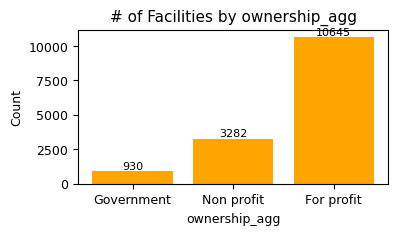

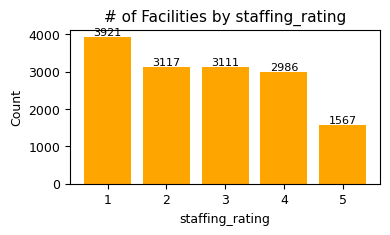

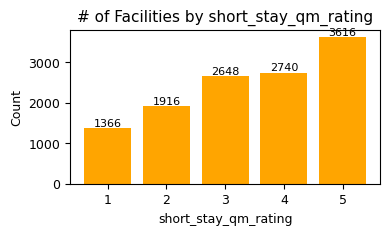

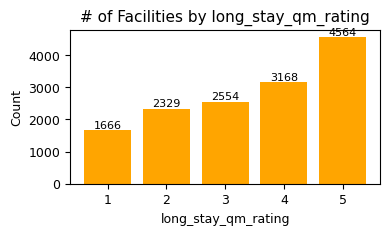

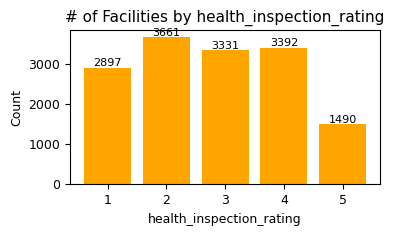

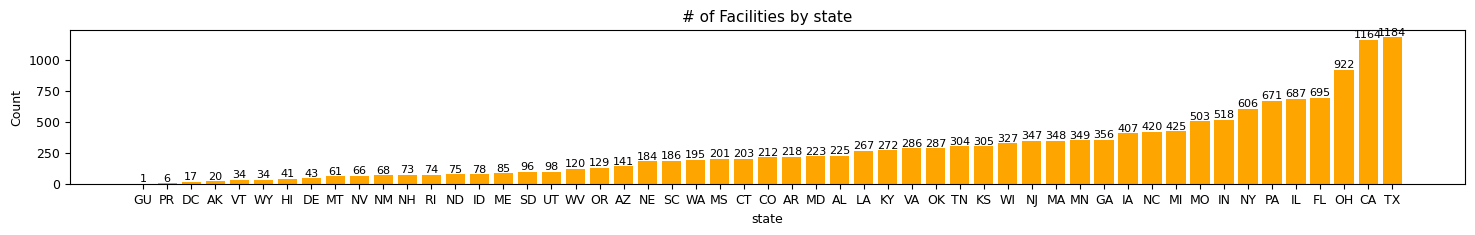

In [11]:
def plot_cat_dist(df, cat_var, color='orange', figsize=(4, 2), sort_by_value=False):
    var_dist = df[cat_var].value_counts().sort_index()
    
    if sort_by_value:
        var_dist = var_dist.sort_values()
    
    # Plot the distribution
    plt.figure(figsize=figsize)
    bars = plt.bar(var_dist.index, var_dist.values, color=color)
    
     # Display the numbers on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontdict={'fontsize':8})

    plt.xlabel(f'{cat_var}', fontsize=9)
    plt.ylabel('Count', fontsize=9)
    plt.title(f'# of Facilities by {cat_var}', fontsize=11)
    plt.xticks(rotation=0,fontsize=9)  
    plt.yticks(fontsize=9)
    plt.gca().set_facecolor('white')
    plt.grid(False)
    plt.show()

df['ownership_agg'] = df['ownership_type'].apply(lambda x: 'For profit' if 'For profit' in x else ('Government' if 'Government' in x else 'Non profit'))
plot_cat_dist(df, 'ownership_agg',sort_by_value=True)
plot_cat_dist(df, 'staffing_rating',sort_by_value=True)
plot_cat_dist(df, 'short_stay_qm_rating',sort_by_value=True)
plot_cat_dist(df, 'long_stay_qm_rating',sort_by_value=True)
plot_cat_dist(df, 'health_inspection_rating',sort_by_value=True)
plot_cat_dist(df, 'state', figsize=(18,2),sort_by_value=True)
#plot_cat_dist(df, 'overall_rating')
#plot_cat_dist(df, 'continuing_care_retirement_community',sort_by_value=True)
#plot_cat_dist(df, 'abuse_icon',sort_by_value=True)
#plot_cat_dist(df, 'most_recent_health_inspection_more_than_2_years_ago',sort_by_value=True)
#plot_cat_dist(df, 'with_a_resident_and_family_council',sort_by_value=True)
#plot_cat_dist(df, 'provider_resides_in_hospital',sort_by_value=True)


## 5. Analysis 1
Are there differences in health inspection, quality measures, and staffing characteristics of nursing homes with different ownership types (for-profit, non-profit, government)?

### 5.1 Performance comparison
Descriptive analysis on nursing home performance across ownership types yield following findings:
- For-profit facilities:
    - Staffing Challenges: for-profit nursing homes exhibit a concerning trend, with 56.1% receiving low staffing ratings (1 and 2). This suggests potential staffing challenges in these facilities, impacting overall performance.
    - Lower Overall Ratings: Across health inspection, staffing, and short-stay quality measures, for-profit facilities tend to have a higher percentage of lower ratings compared to government-owned and non-profit counterparts.
- Non-profit and Government facilities present more balanced distributions across all ratings. Notably, 57% of non-profit nursing homes showcase high short-stay quality measure ratings (4 and 5 stars).

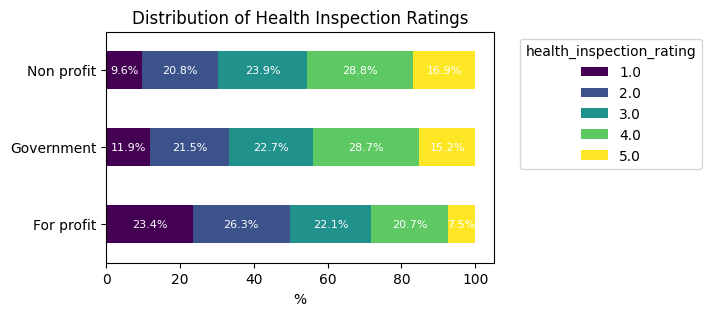

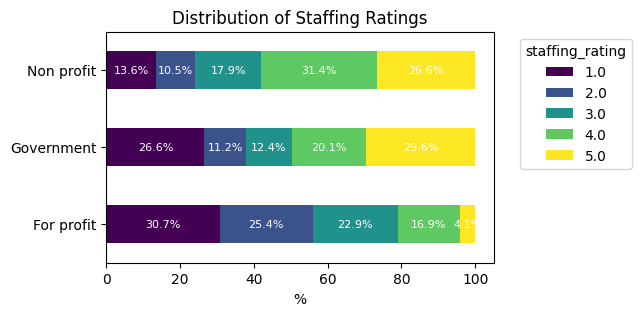

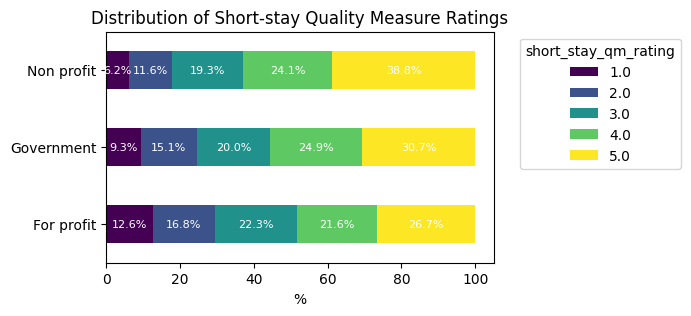

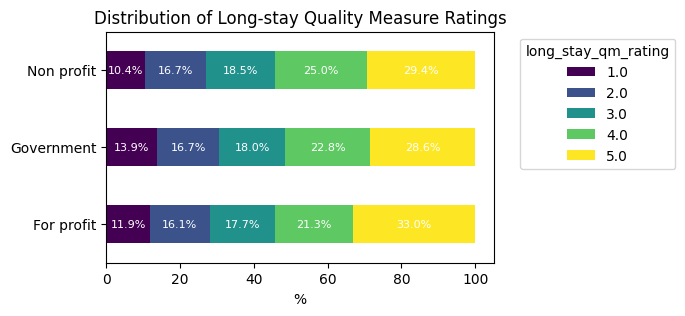

In [12]:
def plot_pct_dist(df, category_col, value_col, title, figsize=(5,3)):
    # Calculate the percentage distribution
    percentage_distribution = df.groupby(category_col)[value_col].value_counts(normalize=True).unstack() * 100
    fig, ax = plt.subplots(figsize=figsize)
    # Horizontal stacked bar plot
    ax = percentage_distribution.plot(kind='barh', stacked=True, cmap='viridis', ax=ax)
    # Set labels, title, legend
    ax.set_xlabel('%')
    ax.set_ylabel('')
    ax.set_title(title)
    ax.legend(title=value_col, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=10)
    # Display individual percentage values inside the bars
    for i, (name, values) in enumerate(zip(percentage_distribution.index, percentage_distribution.values)):
        total = 0
        for value in values:
            ax.text(total + value / 2, i, f'{value:.1f}%', ha='center', va='center', fontsize=8, color='white')
            total += value
    plt.gca().set_facecolor('white')
    plt.grid(False)
    plt.show()
    
#plot_pct_dist(df, 'ownership_agg', 'overall_rating', 'Distribution of Overall Ratings by Agg. Ownership Type')
plot_pct_dist(df, 'ownership_agg', 'health_inspection_rating', 'Distribution of Health Inspection Ratings')
plot_pct_dist(df, 'ownership_agg', 'staffing_rating', 'Distribution of Staffing Ratings')
plot_pct_dist(df, 'ownership_agg', 'short_stay_qm_rating', 'Distribution of Short-stay Quality Measure Ratings')
plot_pct_dist(df, 'ownership_agg', 'long_stay_qm_rating', 'Distribution of Long-stay Quality Measure Ratings')

Special Focus Facilities (SFF) are facilities identified by CMS as the poorest performing facilities nationwide. Notable, 88% of SFFs are for-profit.

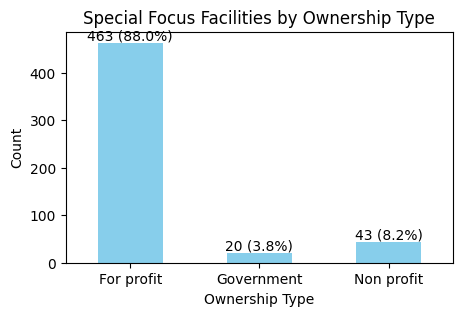

In [13]:
# Filter the data for Special Focus Facilities
sff_data = df[df['special_focus_status'].notnull()]
# Calculate the number and percentage of facilities with SFF status not null by ownership type
ownership_sff_counts = sff_data.groupby('ownership_agg').size()
total_sff_facilities = len(sff_data)
ownership_sff_percentage = ownership_sff_counts / total_sff_facilities * 100

# Plot the results
plt.figure(figsize=(5, 3))
ax = ownership_sff_counts.plot(kind='bar', color='skyblue')
plt.title('Special Focus Facilities by Ownership Type')
plt.xlabel('Ownership Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.gca().set_facecolor('white')
plt.grid(False)

# Display the number and percentage on top of each bar
for i, v in enumerate(ownership_sff_counts):
    percentage = ownership_sff_percentage.iloc[i]
    ax.text(i, v + 0.5, f'{v} ({percentage:.1f}%)', ha='center', va='bottom')

plt.show()

### 5.2 Staffing metrics
- For-profit facilities exhibit higher median values in total nursing staff turnover and registered nurse turnover compared to non-profit and government facilities. 
- Non-profit and government facilities tend to have slightly higher median staffing hours on the weekend, while for-profit facilities show slightly higher median case-mix licensed practical nurse and registered nurse staffing hours. 

In [14]:
# Plot individual horizontal boxplots for each staffing metric
def plot_box(df, features, category_col, figsize=(4, 2)):
    for feature in features:
        plt.figure(figsize=figsize)
        sns.boxplot(x='value', y=category_col, data=df[[feature, category_col]].melt(id_vars=category_col))
        plt.xlabel('')
        plt.ylabel('')
        plt.title(f'{feature}')
        plt.gca().set_facecolor('white')
        plt.grid(False)
        plt.show()

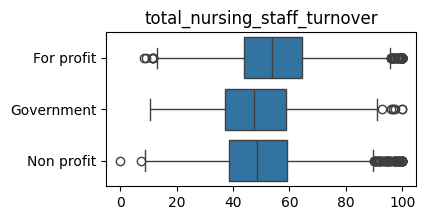

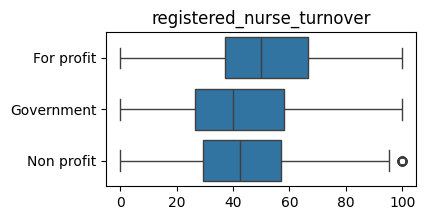

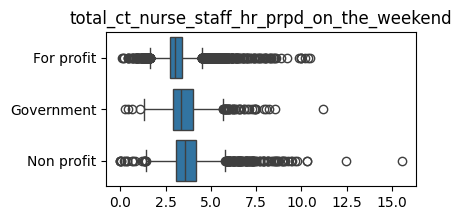

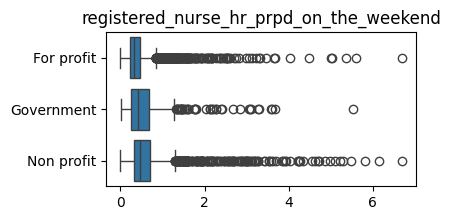

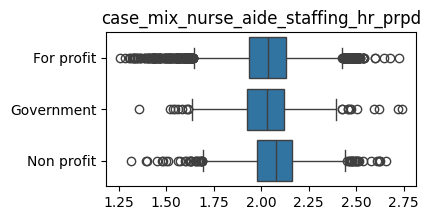

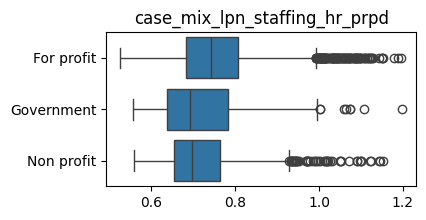

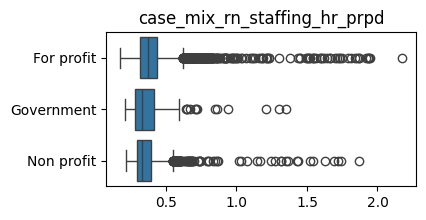

In [15]:
staffing_metrics = ['total_nursing_staff_turnover', 'registered_nurse_turnover',
                    'total_ct_nurse_staff_hr_prpd_on_the_weekend',
       'registered_nurse_hr_prpd_on_the_weekend',
       #'ct_administrators_who_have_left_the_nursing_home',
       'case_mix_nurse_aide_staffing_hr_prpd',
       'case_mix_lpn_staffing_hr_prpd',
       'case_mix_rn_staffing_hr_prpd'
       ]
plot_box(df, staffing_metrics, 'ownership_agg')

### 5.3 Health Inspection Metrics
In the examination of health inspection metrics, a comparison of median values reveals that for-profit facilities tend to have higher counts of health deficiencies, substantiated complaints, reported incidents, penalties, and hence amount of fines in dollars, compared to non-profit and government facilities

In [16]:
inspection_metrics = [
       'rating_cycle_1_ct_standard_health_deficiencies',
       'rating_cycle_1_ct_complaint_health_deficiencies',
       'rating_cycle_1_health_deficiency_score',
       'rating_cycle_1_ct_health_revisits',
       'rating_cycle_1_health_revisit_score',
       'total_weighted_health_survey_score',
       'ct_facility_reported_incidents',
       'ct_substantiated_complaints',
       'ct_citations_from_infection_control_inspections',
       'total_amount_of_fines_in_dollars',
       'ct_payment_denials', 'total_ct_penalties']
desc_stats = df.groupby('ownership_agg')[inspection_metrics].describe().transpose()
selected_percentiles = ['min', '25%', '50%', '75%', 'max']
filtered_desc_stats = desc_stats.loc(axis=0)[:, selected_percentiles].round(1)
display(filtered_desc_stats)

ownership_agg                                        For profit  Government  \
rating_cycle_1_ct_standard_health_deficiencies  min         0.0         0.0   
                                                25%         3.0         2.0   
                                                50%         6.0         4.0   
                                                75%        11.0         7.0   
                                                max        69.0        53.0   
rating_cycle_1_ct_complaint_health_deficiencies min         0.0         0.0   
                                                25%         0.0         0.0   
                                                50%         1.0         0.0   
                                                75%         5.0         2.0   
                                                max        68.0        62.0   
rating_cycle_1_health_deficiency_score          min         0.0         0.0   
                                                25%        24.0        12.0   
                                                50%        52.0        32.0   
                                                75%       100.0        60.0   
                                                max      1791.0      1329.0   
rating_cycle_1_ct_health_revisits               min         0.0         0.0   
                                                25%         1.0         1.0   
                                                50%         1.0         1.0   
                                                75%         1.0         1.0   
                                                max         4.0         3.0   
rating_cycle_1_health_revisit_score             min         0.0         0.0   
                                                25%         0.0         0.0   
                                                50%         0.0         0.0   
                                                75%         0.0         0.0   
                                                max      1522.0       386.0   
total_weighted_health_survey_score              min         0.0         0.0   
                                                25%        28.7        20.0   
                                                50%        56.0        37.7   
                                                75%       104.0        62.5   
                                                max      1669.2       771.2   
ct_facility_reported_incidents                  min         0.0         0.0   
                                                25%         0.0         0.0   
                                                50%         0.0         0.0   
                                                75%         2.0         2.0   
                                                max        90.0        41.0   
ct_substantiated_complaints                     min         0.0         0.0   
                                                25%         0.0         0.0   
                                                50%         3.0         1.0   
                                                75%         9.0         3.0   
                                                max       208.0        67.0   
ct_citations_from_infection_control_inspections min         0.0         0.0   
                                                25%         0.0         0.0   
                                                50%         0.0         0.0   
                                                75%         2.0         1.0   
                                                max        43.0        13.0   
total_amount_of_fines_in_dollars                min         0.0         0.0   
                                                25%         0.0         0.0   
                                                50%      9750.0      6093.7   
                                                75%     41388.7     27304.7   
                                                ma

### 5.4 General Facility Metrics
I also examined general facility information, including the number of certified beds, average number of residents per day, time in practice, and average occupancy ratio, there were no prominent differences observed among ownership types. The median values across the three groups were similar, and the presence of numerous outliers made direct comparisons challenging.

### 5.5 Next steps
- Investigate specific factors contributing to staffing challenges in for-profit facilities
- Conduct regional analyses to identify variations in performance that may be influenced by geographical factors.

## 6. Analysis 2
Is there any correlation between the demographic characteristics of the county and the quality of care in nursing homes, specifically:
- Do facilities in more urban or affluent counties have better staffing, health inspection, quality measure, higher occupancy rate? 
- Others:
    - Where are new facilities opened (which state/ urban or rural/ affluent or not)?
    - Are new facilities better than old ones?
    - Are bigger facilities better than old ones?
    - Most facilities are in non-urban areas

* Note that star ratings are comparative within state, not across the US


### 6.1 The majority of facilities are located in non-urban areas

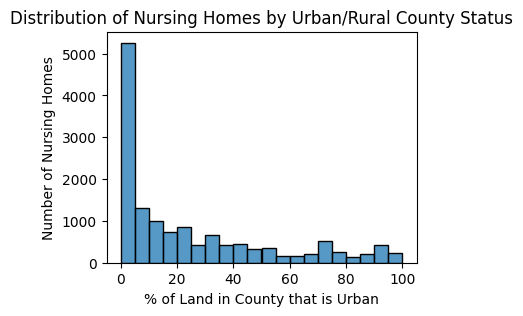

In [17]:
plt.figure(figsize=(4, 3))
sns.histplot(x='aland_pct_urb', data=df, bins=20, kde=False)
plt.title('Distribution of Nursing Homes by Urban/Rural County Status')
plt.xlabel('% of Land in County that is Urban')
plt.ylabel('Number of Nursing Homes')
plt.show()

### 6.2 Correlation matrix analysis revealed very weak correlations between county demographic characteristics (urban and income) and nursing home performance metrics in staffing and health inspection.

In [18]:
def plot_heatmap(df, metrics, title='X metrics', figsize=(10,6)):
    corr_metrix = df[metrics].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr_metrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title(f'Corr matrix of {title} & county urban & income characteristics')
    plt.xticks(rotation=20, ha='right')
    plt.show()

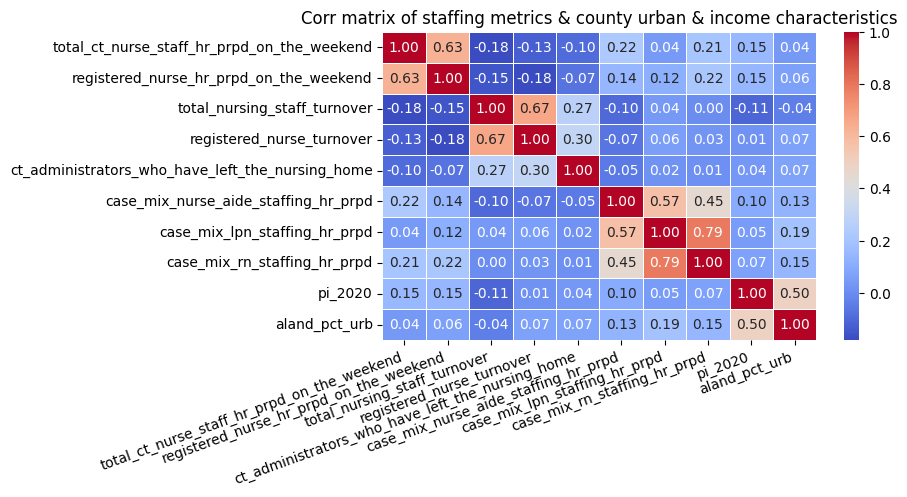

In [19]:
staffing_metrics = ['total_ct_nurse_staff_hr_prpd_on_the_weekend',
       'registered_nurse_hr_prpd_on_the_weekend',
       'total_nursing_staff_turnover', 'registered_nurse_turnover',
       'ct_administrators_who_have_left_the_nursing_home',
       'case_mix_nurse_aide_staffing_hr_prpd',
       'case_mix_lpn_staffing_hr_prpd',
       'case_mix_rn_staffing_hr_prpd']
staffing_metrics_cou = staffing_metrics + ['pi_2020','aland_pct_urb']
plot_heatmap(df, staffing_metrics_cou, "staffing metrics", (7,4))

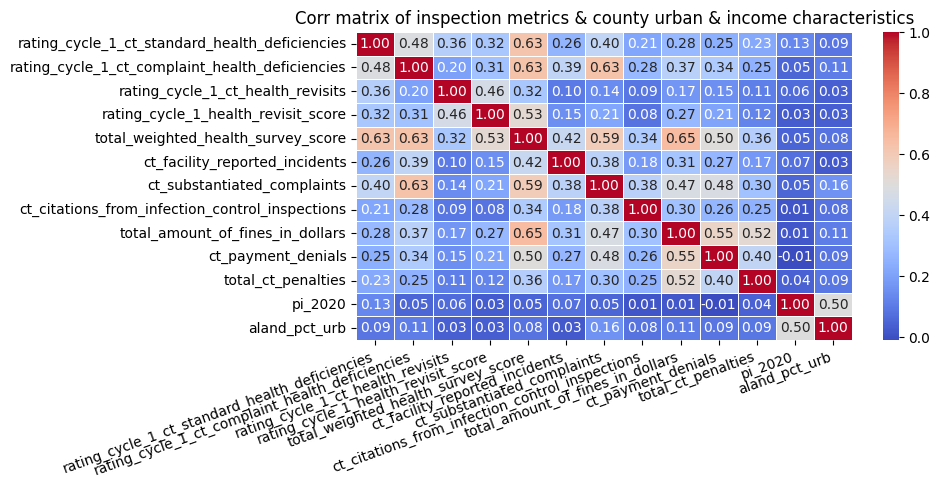

In [20]:
inspection_metrics = [
       'rating_cycle_1_ct_standard_health_deficiencies',
       'rating_cycle_1_ct_complaint_health_deficiencies',
       'rating_cycle_1_ct_health_revisits',
       'rating_cycle_1_health_revisit_score',
       'total_weighted_health_survey_score',
       'ct_facility_reported_incidents',
       'ct_substantiated_complaints',
       'ct_citations_from_infection_control_inspections',
       'total_amount_of_fines_in_dollars',
       'ct_payment_denials', 'total_ct_penalties'
       ]
inspection_metrics_cou = inspection_metrics+['pi_2020','aland_pct_urb']
plot_heatmap(df, inspection_metrics_cou, "inspection metrics",(8,4))


### 6.3 Conclusion:
- County-level urban and income features alone may not be strong predictors of staffing, health inspection outcomes, or other quality measures in nursing homes.
- Next steps: Explore potential interactions between demographic characteristics and other variables to gain a more comprehensive understanding